# Make prediction with trained DeepSDM

## Load packages

In [1]:
import time
import torch
import pytorch_lightning as pl
from types import SimpleNamespace
import mlflow
from pytorch_lightning.strategies import DDPStrategy
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from LitDeepSDMData import LitDeepSDMData
from LitUNetSDM import LitUNetSDM
import os
from matplotlib import pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model configuration
Some settings do not matter here. Just copy these configs from 02_train_deepsdm.py

In [2]:
# load configurations
with open('DeepSDM_conf.yaml', 'r') as f:
    DeepSDM_conf = yaml.load(f, Loader = yaml.FullLoader)
DeepSDM_conf = SimpleNamespace(**DeepSDM_conf)

date_list = []
# lists of selected dates for training
# format: YYYY_MM_01
# The python range exclude the stop value (here e.g. 2020)
# So here we generate from 2016_01_01 to 2019_12_01
# We keep data of 2020 for validation/prediction
for y_ in range(2000, 2019):
    for m_ in range(1, 13):
        date_list.append(f'{y_:04d}-{m_:02d}-01')

# packed the species lists and date lists for training
info = SimpleNamespace(**dict(
    env_list = sorted(DeepSDM_conf.env_list),
    non_normalize_env_list = sorted(DeepSDM_conf.non_normalize_env_list),
    species_list = sorted(DeepSDM_conf.species_list),
    species_list_val = sorted(DeepSDM_conf.species_list),
    species_list_smoothviz = sorted(DeepSDM_conf.species_list_smoothviz),
    date_list = sorted(date_list),
    date_list_val = sorted(date_list),
    date_list_smoothviz = sorted(DeepSDM_conf.date_list_smoothviz)
))


conf = SimpleNamespace(**DeepSDM_conf.conf)
conf.num_env = len(DeepSDM_conf.env_list) # number of environmental layers
conf.num_vector = DeepSDM_conf.embedding['num_vector'] # number of vectors for the embeddings of species co-occurrence

## Load parameters from the checkpoint of a trained model

Find the latest version or assign the version yourself under the lightning_logs directory and load parameters from its checkpoints.

In [3]:
path = 'lightning_logs'
only_dirs = [d for d in os.listdir('lightning_logs') if os.path.isdir(os.path.join(path, d)) and not d.endswith('.ipynb_checkpoints')]
sorted_dirs = sorted(only_dirs, key=lambda x: os.path.getmtime(os.path.join(path, x)))
# version = sorted_dirs[-1]
version = 'version_16'
checkpoint_path = f'{path}/{version}/checkpoints'
checkpoints = [f for f in os.listdir(checkpoint_path) if f.endswith('.ckpt') and f != 'last.ckpt']
checkpoints

['epoch=47-step=8304.ckpt']

In [4]:
model = LitUNetSDM.load_from_checkpoint(f'{checkpoint_path}/{checkpoints[0]}', info=info, conf=conf)

## Initialize datamodel

In [5]:
deep_sdm_data = LitDeepSDMData(info = info, conf = conf)

./workspace/env_information.json
./workspace/species_information.json
./workspace/k_information.json
./workspace/cooccurrence_vector.json


## Select the species and dates for prediction.
The format of date must be YYYY_MM_01

In [6]:
# The Carpodacus_formosanus is a species unknown to the model in the training process.
# We can still predict its distribution with help of species embeddings.
# We can also assign multiple species and dates for batch predictions. 
date_list_predict = []
for y_ in range(2018, 2019):
    for m_ in range(1, 13):
        date_list_predict.append(f'{y_:04d}-{m_:02d}-01')
predict_dataloaders = deep_sdm_data.predict_dataloader(species_list = DeepSDM_conf.species_list_predict, date_list = date_list_predict)

Setting up dataset for prediction...


## Start prediction
The results inlcuding png images and geotiff will be output to the `output_dir`

In [7]:
model.eval()
with torch.no_grad():
    raw_results = model.predict(predict_dataloaders, datamodule = deep_sdm_data, output_dir = 'predicts')

In [10]:
raw_results.keys()

dict_keys(['_Passer-cinnamomeus-2018-01-01', '_Passer-cinnamomeus-2018-02-01', '_Passer-cinnamomeus-2018-03-01', '_Passer-cinnamomeus-2018-04-01', '_Passer-cinnamomeus-2018-05-01', '_Passer-cinnamomeus-2018-06-01', '_Passer-cinnamomeus-2018-07-01', '_Passer-cinnamomeus-2018-08-01', '_Passer-cinnamomeus-2018-09-01', '_Passer-cinnamomeus-2018-10-01', '_Passer-cinnamomeus-2018-11-01', '_Passer-cinnamomeus-2018-12-01', '_Carpodacus-formosanus-2018-01-01', '_Carpodacus-formosanus-2018-02-01', '_Carpodacus-formosanus-2018-03-01', '_Carpodacus-formosanus-2018-04-01', '_Carpodacus-formosanus-2018-05-01', '_Carpodacus-formosanus-2018-06-01', '_Carpodacus-formosanus-2018-07-01', '_Carpodacus-formosanus-2018-08-01', '_Carpodacus-formosanus-2018-09-01', '_Carpodacus-formosanus-2018-10-01', '_Carpodacus-formosanus-2018-11-01', '_Carpodacus-formosanus-2018-12-01', '_Acridotheres-cristatellus-2018-01-01', '_Acridotheres-cristatellus-2018-02-01', '_Acridotheres-cristatellus-2018-03-01', '_Acridotheres

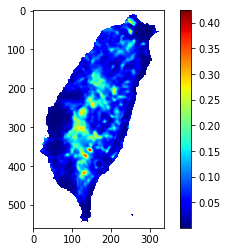

In [11]:
plt.imshow(
    raw_results['_Passer-cinnamomeus-2018-01-01'][1],
    cmap='jet',
)
plt.colorbar()